In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F 
#substring, unix_timestamp, when, col, avg, round, to_date, desc, row_number
from pyspark.sql.window import Window
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely import wkt
import pandas as pd
from shapely import wkt
import numpy as np

spark = SparkSession.builder.appName("final_peoject").getOrCreate()
# spark = SparkSession.builder.appName("final_peoject").master("local[*]").getOrCreate()
# input_path = "dob_nyc_200.csv"
# input_path = "DOB_Job_Application_Filings_20240424.csv"
input_path = "dob_nyc_project.csv"

df = spark.read.csv(input_path, header=True, inferSchema=True)

time_fmt = "MM/dd/yyyy"
time_re = "\d{2}/\d{2}/\d{4}"

def group_building_class(building_class):

    if building_class in ['A', 'B', 'C', 'D', 'R', 'S']:
        return 'res'

    # Commercial and Industrial Buildings
    elif building_class in ['J', 'K', 'L', 'O']:
        return 'comm'
    elif building_class in ['E', 'F', 'G']:
        return 'ind'
    elif building_class in ['H', 'Q']:
        return 'rec'
    
    # Special Purpose Buildings
    elif building_class in ['I']:
        return 'health'
    elif building_class in ['M', 'P']:
        return 'culRel'
    elif building_class in ['Y']:
        return 'gov'
    elif building_class in ['T', 'U']:
        return 'utilTr'
    elif building_class in ['W']:
        return 'edu'
    elif building_class in ['N']:
        return 'asy'
   
    # Miscellaneous and Land
    elif building_class in ['Z']:
        return 'misc'
    elif building_class in ['V']:
        return 'vLand'
    
    else:
        return None
        

def label_building_class(building_class):
  
    labels = {
        'A': 'sf',       # Single Family
        'B': 'tf',       # Two Family
        'C': 'apt',      # Apartments
        'D': 'aptEl',   # Apartments (Elevator)
        'E': 'wh',       # Warehouses
        'F': 'fac',      # Factories
        'G': 'gar',      # Garages
        'H': 'hot',      # Hotels
        'I': 'hosp',     # Hospitals
        'J': 'th',       # Theatres
        'K': 'sto',      # Stores
        'L': 'lo',       # Lofts
        'M': 'rel',      # Religious Facilities
        'N': 'asy',      # Asylums
        'O': 'off',      # Offices
        'P': 'cul',      # Cultural
        'Q': 'rec',      # Recreation
        'R': 'con',      # Condominiums
        'S': 'mix',      # Mixed Use
        'T': 'tran',     # Transportation
        'U': 'util',     # Utility
        'V': 'vLand',    # Vacant Land
        'W': 'edu',      # Education
        'Y': 'gov',      # Government
        'Z': 'misc'      # Miscellaneous
    }

    return labels[building_class] if building_class in labels else None

df = df.select(df["Job Type"].alias("job_type"), df["BUILDING_CLASS"].alias("building_class_detail"), F.substring(df["BUILDING_CLASS"], 1, 1).alias("building"), df["Pre- Filing Date"].alias("pre_filling"), df["Paid"].alias("paid"), df["Fully Paid"].alias("paid_fully"), df["Assigned"].alias("assigned"), df["Approved"].alias("approved"), df["Fully Permitted"].alias("permitted"), df["SIGNOFF_DATE"].alias("signoff"), df["Borough"].alias("borough"), df["GIS_LATITUDE"].alias("gis_lat"), df["GIS_LONGITUDE"].alias("gis_long"))
df = df.withColumn("building_type", F.udf(group_building_class)(F.col("building")))
df = df.withColumn("building_class", F.udf(label_building_class)(F.col("building")))
df = df.drop("building")
df.show(1)
df.count()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/01 23:43:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/01 23:43:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------+---------------------+-----------+----------+----------+--------+----------+----------+----------+--------+---------+----------+-------------+--------------+
|job_type|building_class_detail|pre_filling|      paid|paid_fully|assigned|  approved| permitted|   signoff| borough|  gis_lat|  gis_long|building_type|building_class|
+--------+---------------------+-----------+----------+----------+--------+----------+----------+----------+--------+---------+----------+-------------+--------------+
|      A2|                   S2| 04/16/2004|04/20/2004|04/20/2004|    NULL|04/20/2004|05/12/2004|11/28/2005|BROOKLYN|40.717318|-73.955431|          res|           mix|
+--------+---------------------+-----------+----------+----------+--------+----------+----------+----------+--------+---------+----------+-------------+--------------+
only showing top 1 row



2708134

In [2]:
df_nyc = pd.read_csv('nybb.csv')
df_nyc['geometry'] = df_nyc['geometry'].apply(wkt.loads)
nyc = gpd.GeoDataFrame(df_nyc, crs='epsg:4326')

df_map_job = df.select("job_type", "gis_lat", "gis_long").na.drop()
df_map_job.show(1)
df_map_job_pd = df_map_job.toPandas()
geometry_job = [Point(lon, lat) for lon, lat in zip(df_map_job_pd["gis_long"], df_map_job_pd["gis_lat"])]
gdf_points_job = gpd.GeoDataFrame(df_map_job_pd, geometry=geometry_job, crs='EPSG:4326')

df_map_building = df.select(
    "building_class", "building_type", "gis_lat", "gis_long",
    F.when(F.col("pre_filling").rlike(time_re), F.to_date(F.col("pre_filling"), time_fmt)).alias("pre_filling_date")
).na.drop()

df_map_building_rank = Window.partitionBy("gis_lat", "gis_long").orderBy(F.desc("pre_filling_date"))
df_map_building = df_map_building.withColumn("row_num", F.row_number().over(df_map_building_rank))
df_map_building = df_map_building.filter(F.col("row_num") == 1)
df_map_building = df_map_building.select("building_class", "building_type", "gis_lat", "gis_long")
df_map_building.show(1)
df_map_building_pd = df_map_building.toPandas()
geometry_building = [Point(lon, lat) for lon, lat in zip(df_map_building_pd["gis_long"], df_map_building_pd["gis_lat"])]
gdf_points_building = gpd.GeoDataFrame(df_map_building_pd, geometry=geometry_building, crs='EPSG:4326')


+--------+---------+----------+
|job_type|  gis_lat|  gis_long|
+--------+---------+----------+
|      A2|40.717318|-73.955431|
+--------+---------+----------+
only showing top 1 row



+--------------+-------------+---------+----------+
|building_class|building_type|  gis_lat|  gis_long|
+--------------+-------------+---------+----------+
|            tf|          res|40.498966|-74.241546|
+--------------+-------------+---------+----------+
only showing top 1 row



In [3]:
def plot_map(gdf_points, col, color, title):   
    
    fig, ax = plt.subplots(figsize=(16, 16))

    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    nyc.plot(ax=ax, color="white", edgecolor="black")
    gdf_points.plot(ax=ax, column=col, categorical=True, legend=True, cmap=color, markersize=1)
 
    # plt.show()
    plt.savefig(title.lower().replace(" ", "_"))

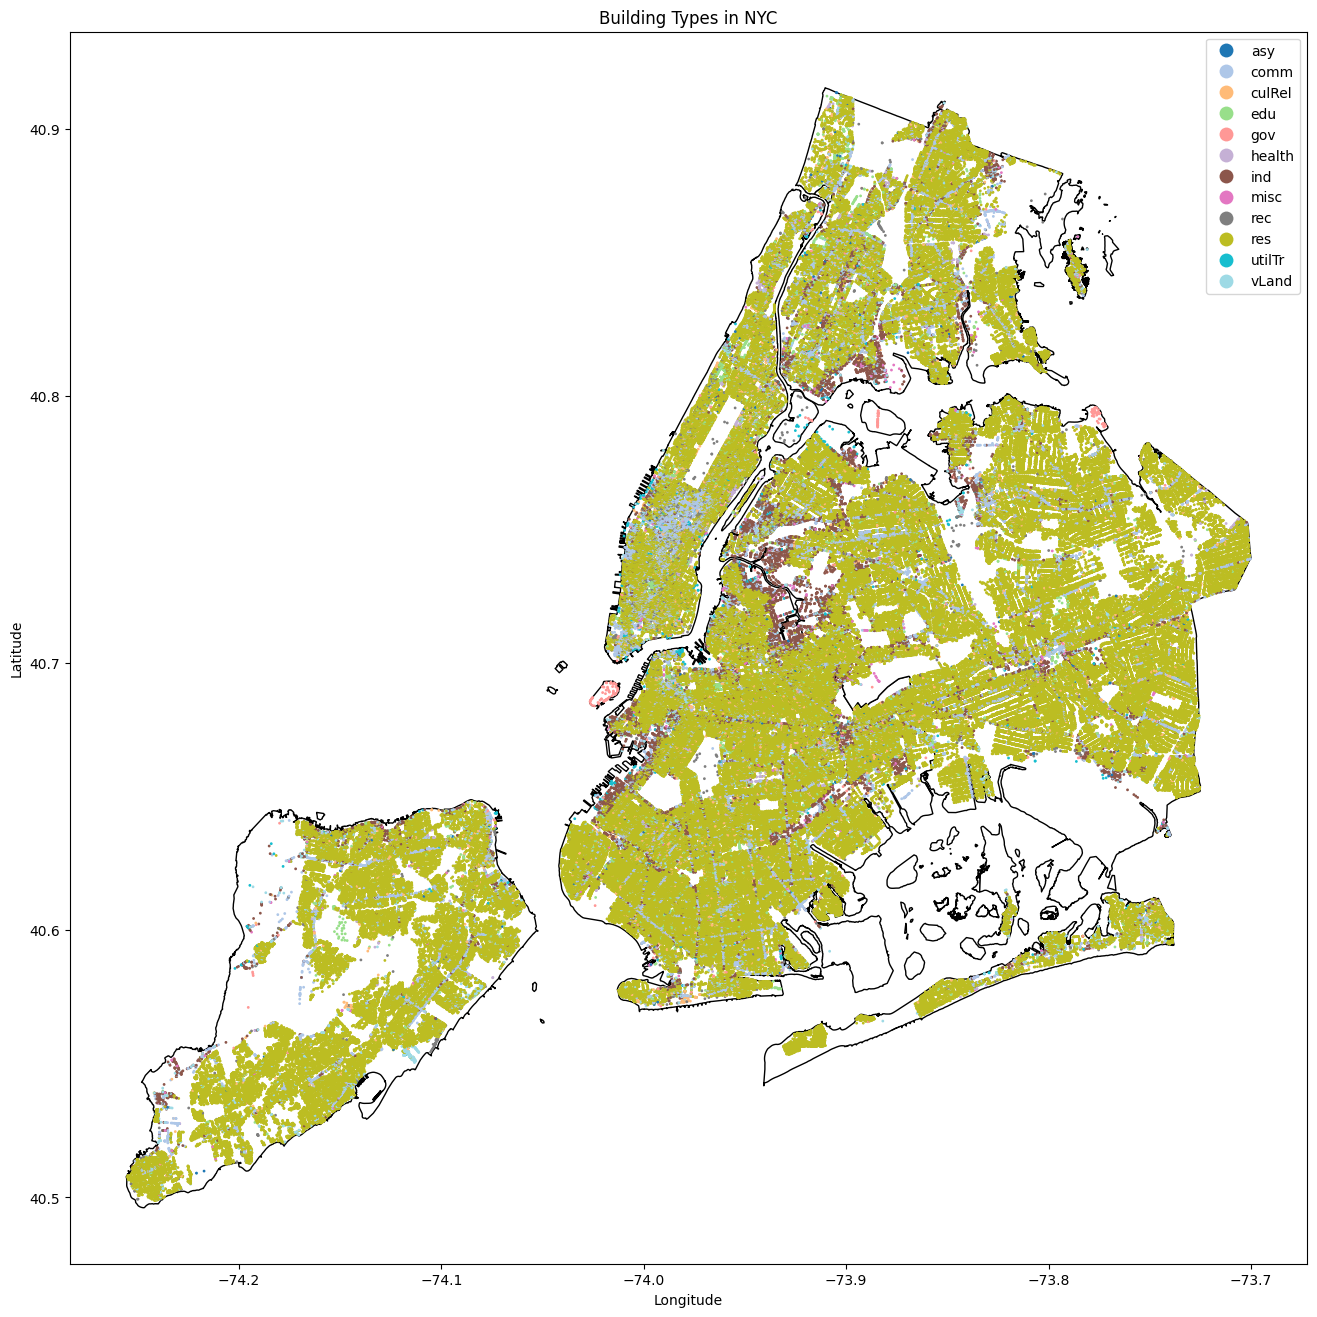

In [4]:
plot_map(gdf_points_building, "building_type", "tab20", "Building Types in NYC")

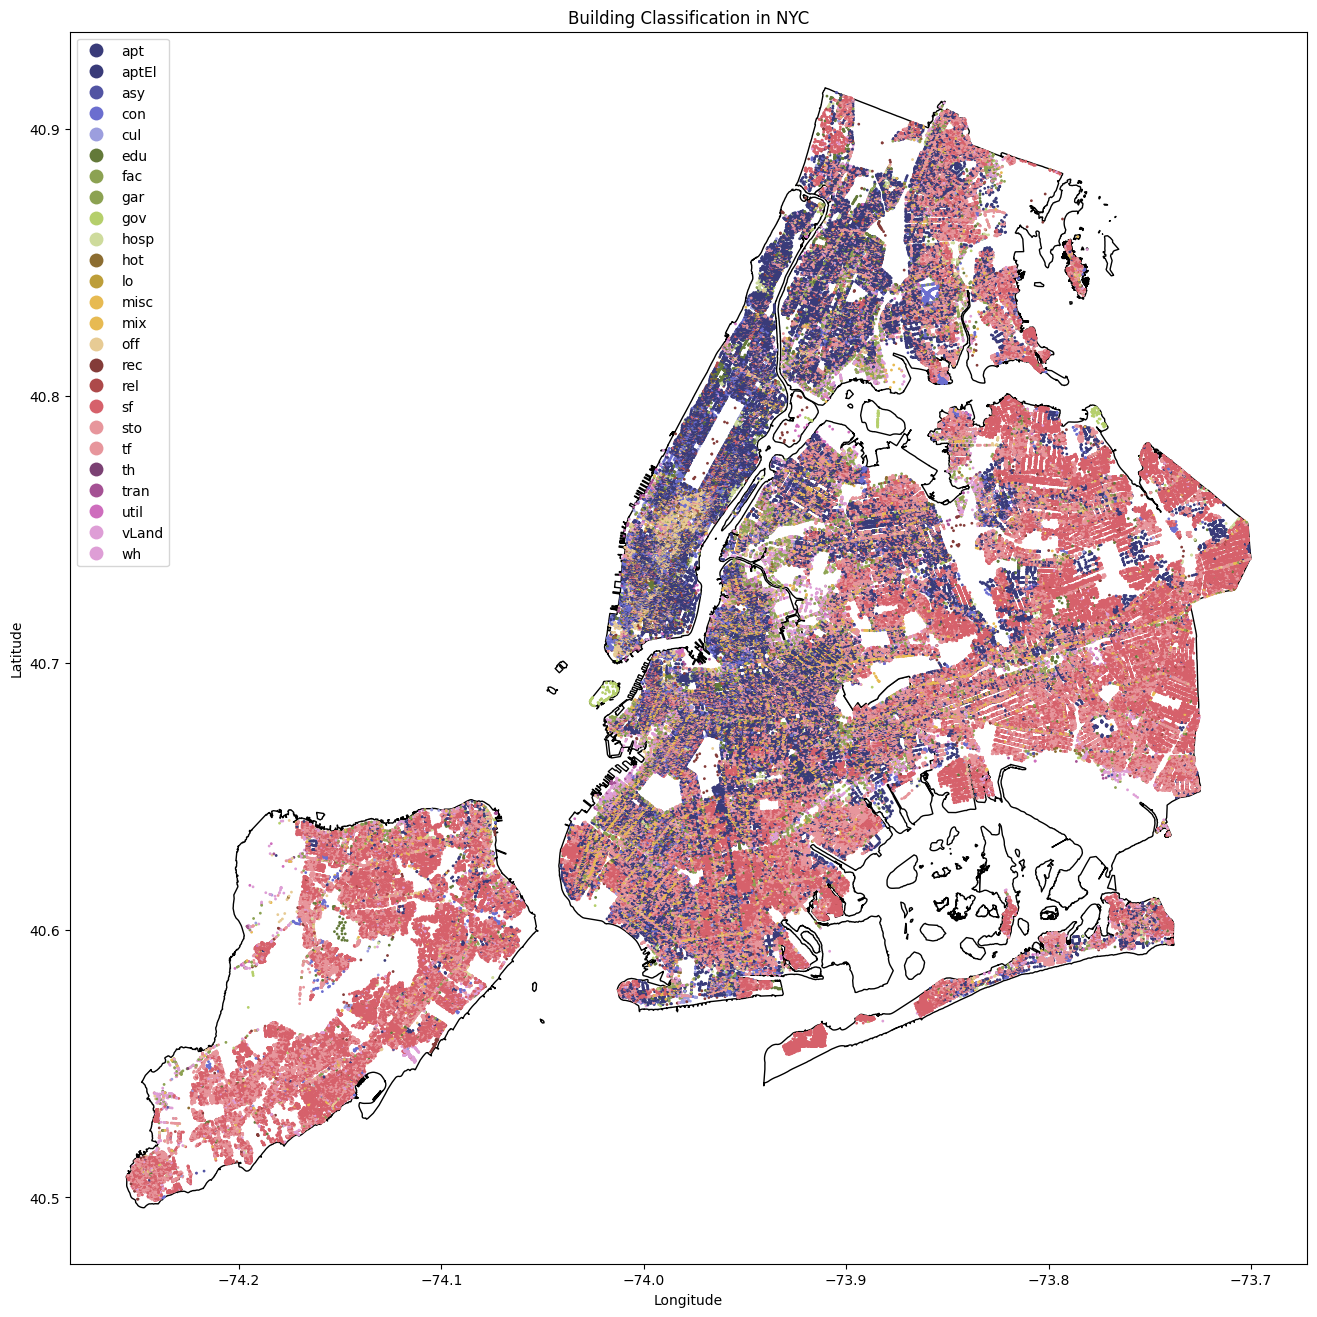

In [5]:
plot_map(gdf_points_building, "building_class", "tab20b", "Building Classification in NYC")


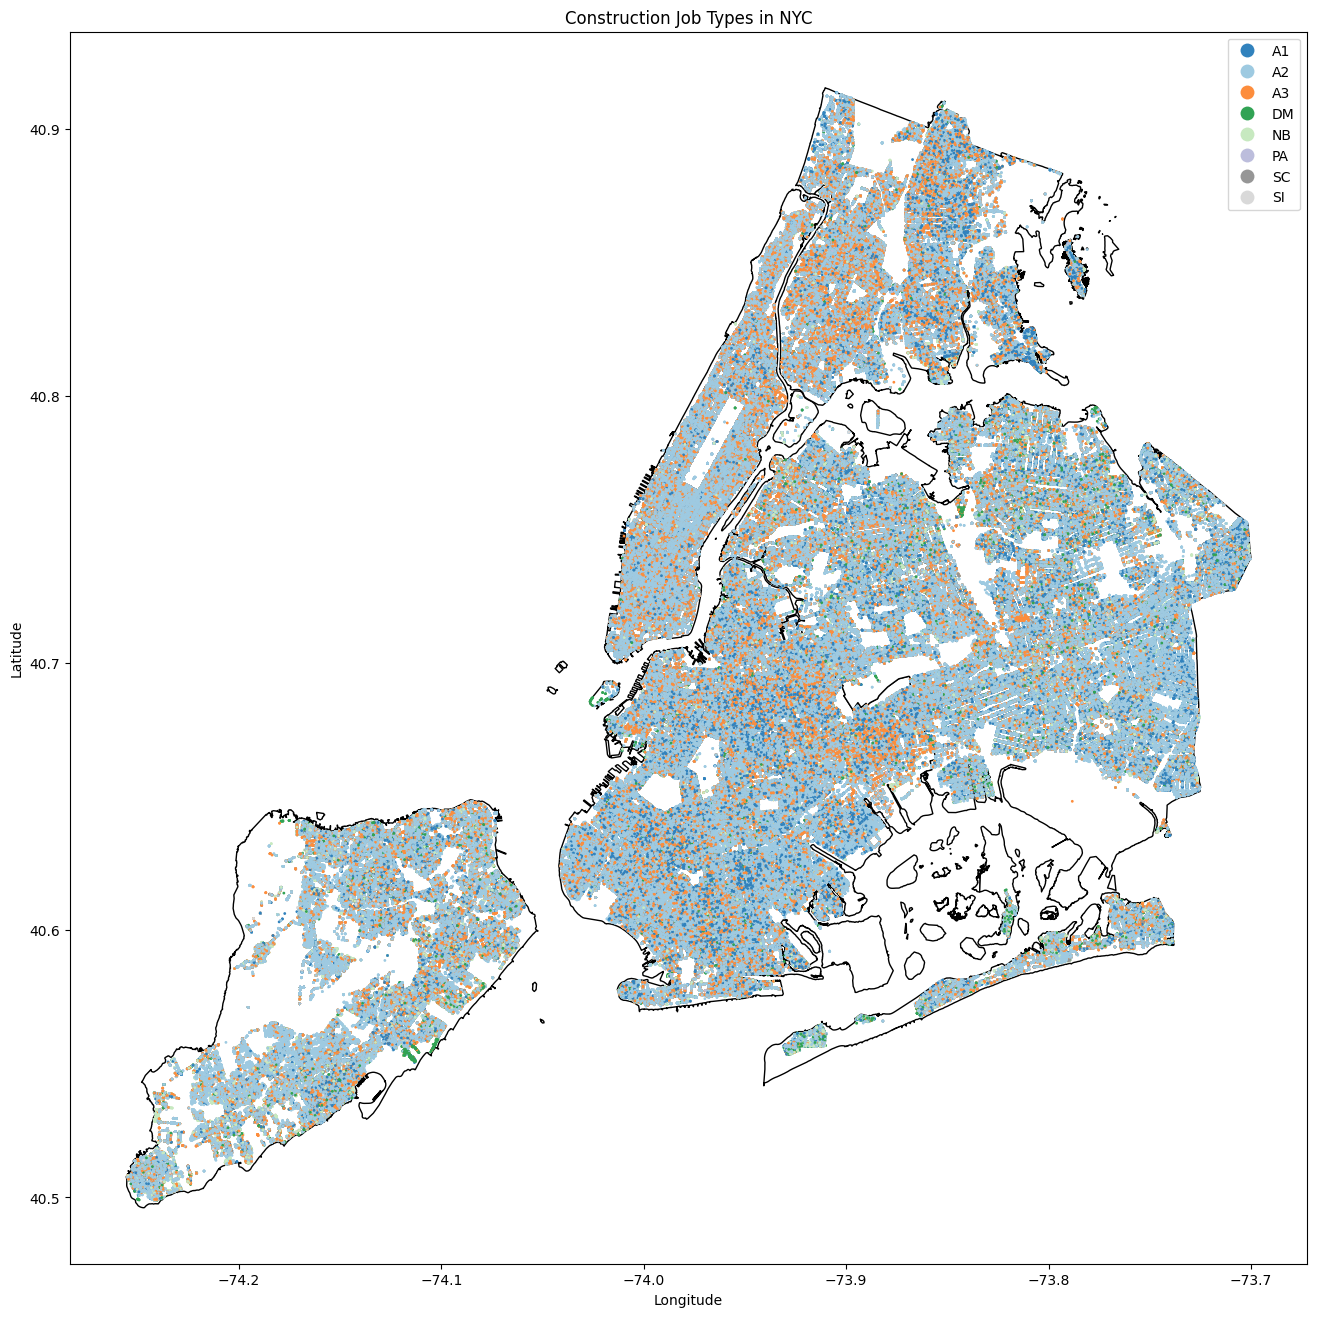

In [6]:
plot_map(gdf_points_job, "job_type", "tab20c", "Construction Job Types in NYC")

In [7]:

df_time = df.select("job_type", "building_class_detail", "building_class", "building_type", "pre_filling", "paid", "paid_fully", "assigned", "approved", "permitted", "signoff", "borough")
df_time.show(5)

def time_diff(col1, col2):
    condition = ((F.col(col1).rlike(time_re) & F.to_date(F.col(col1), time_fmt).isNotNull()) &
                 (F.col(col2).rlike(time_re) & F.to_date(F.col(col2), time_fmt).isNotNull()))
    
    diff_seconds = F.when(condition, F.unix_timestamp(col1, format=time_fmt) - F.unix_timestamp(col2, format=time_fmt))
    
    diff_days = F.round(diff_seconds / (24 * 3600)).cast("int")
    
    return F.when(diff_days < 0, None).otherwise(diff_days).cast("int")

def time_diff_neg(col1, col2):
    
    condition = ((F.col(col1).rlike(time_re) & F.to_date(F.col(col1), time_fmt).isNotNull()) &
                 (F.col(col2).rlike(time_re) & F.to_date(F.col(col2), time_fmt).isNotNull()))
    
    diff_seconds = F.when(condition, F.unix_timestamp(col1, format=time_fmt) - F.unix_timestamp(col2, format=time_fmt))
    
    diff_days = F.round(diff_seconds / (24 * 3600)).cast("int")
    
    return diff_days
    
df_time = df_time.withColumn("approved_new", time_diff_neg("approved", "assigned"))
df_time = df_time.filter((F.col("approved_new").isNull()) | (F.col("approved_new") >= 0))

df_timeline = df_time.select(
    "borough", 
    "building_class_detail",
    "building_class",
    "building_type",
    "job_type",
    time_diff("paid", "pre_filling").alias("paid"),
    time_diff("paid_fully", "paid").alias("paid_fully"),
    time_diff("assigned", "paid_fully").alias("assigned"),
    F.col("approved_new").alias("approved"),
    time_diff("permitted", "approved").alias("permitted"),
    time_diff("signoff", "permitted").alias("signoff")
)

df_timeline.show(5) 

df_timeline_borough = df_timeline.na.drop(subset=["borough"]).groupBy("borough").agg(
    F.round(F.avg("paid")).cast("int").alias("avg_paid"),
    F.round(F.avg("paid_fully")).cast("int").alias("avg_paid_fully"),
    F.round(F.avg("assigned")).cast("int").alias("avg_assigned"),
    F.round(F.avg("approved")).cast("int").alias("avg_approved"),
    F.round(F.avg("permitted")).cast("int").alias("avg_permitted"),
    F.round(F.avg("signoff")).cast("int").alias("avg_signoff")
)
df_timeline_building_class = df_timeline.na.drop(subset=["building_class"]).groupBy("building_class").agg(
    F.round(F.avg("paid")).cast("int").alias("avg_paid"),
    F.round(F.avg("paid_fully")).cast("int").alias("avg_paid_fully"),
    F.round(F.avg("assigned")).cast("int").alias("avg_assigned"),
    F.round(F.avg("approved")).cast("int").alias("avg_approved"),
    F.round(F.avg("permitted")).cast("int").alias("avg_permitted"),
    F.round(F.avg("signoff")).cast("int").alias("avg_signoff")
)

df_timeline_building_type = df_timeline.na.drop(subset=["building_type"]).groupBy("building_type").agg(
    F.round(F.avg("paid")).cast("int").alias("avg_paid"),
    F.round(F.avg("paid_fully")).cast("int").alias("avg_paid_fully"),
    F.round(F.avg("assigned")).cast("int").alias("avg_assigned"),
    F.round(F.avg("approved")).cast("int").alias("avg_approved"),
    F.round(F.avg("permitted")).cast("int").alias("avg_permitted"),
    F.round(F.avg("signoff")).cast("int").alias("avg_signoff")
)

df_timeline_job = df_timeline.na.drop(subset=["job_type"]).groupBy("job_type").agg(
    F.round(F.avg("paid")).cast("int").alias("avg_paid"),
    F.round(F.avg("paid_fully")).cast("int").alias("avg_paid_fully"),
    F.round(F.avg("assigned")).cast("int").alias("avg_assigned"),
    F.round(F.avg("approved")).cast("int").alias("avg_approved"),
    F.round(F.avg("permitted")).cast("int").alias("avg_permitted"),
    F.round(F.avg("signoff")).cast("int").alias("avg_signoff")
)

df_timeline_building = df_timeline.na.drop(subset=["building_class_detail"]).groupBy("building_class_detail").agg(
    F.round(F.avg("paid")).cast("int").alias("avg_paid"),
    F.round(F.avg("paid_fully")).cast("int").alias("avg_paid_fully"),
    F.round(F.avg("assigned")).cast("int").alias("avg_assigned"),
    F.round(F.avg("approved")).cast("int").alias("avg_approved"),
    F.round(F.avg("permitted")).cast("int").alias("avg_permitted"),
    F.round(F.avg("signoff")).cast("int").alias("avg_signoff")
)

df_timeline_borough.show()
df_timeline_building_class.show(5)
df_timeline_building_type.show(5)
df_timeline_building.show(5)
df_timeline_job.show(5)

+--------+---------------------+--------------+-------------+-----------+----------+----------+----------+----------+----------+----------+--------+
|job_type|building_class_detail|building_class|building_type|pre_filling|      paid|paid_fully|  assigned|  approved| permitted|   signoff| borough|
+--------+---------------------+--------------+-------------+-----------+----------+----------+----------+----------+----------+----------+--------+
|      A2|                   S2|           mix|          res| 04/16/2004|04/20/2004|04/20/2004|      NULL|04/20/2004|05/12/2004|11/28/2005|BROOKLYN|
|      A1|                   C0|           apt|          res| 04/16/2004|04/16/2004|04/16/2004|04/19/2004|04/19/2004|07/15/2004|10/26/2006|BROOKLYN|
|      A1|                   R0|           con|          res| 05/23/2006|05/24/2006|05/24/2006|05/09/2022|01/04/2007|01/05/2007|      NULL|BROOKLYN|
|      A2|                   A2|            sf|          res| 05/03/2021|05/03/2021|05/03/2021|05/03/2021|

+--------+---------------------+--------------+-------------+--------+----+----------+--------+--------+---------+-------+
| borough|building_class_detail|building_class|building_type|job_type|paid|paid_fully|assigned|approved|permitted|signoff|
+--------+---------------------+--------------+-------------+--------+----+----------+--------+--------+---------+-------+
|BROOKLYN|                   S2|           mix|          res|      A2|   4|         0|    NULL|    NULL|       22|    565|
|BROOKLYN|                   C0|           apt|          res|      A1|   0|         0|       3|       0|       87|    833|
|  QUEENS|                   A2|            sf|          res|      A2|   0|         0|       0|       0|        4|    292|
|  QUEENS|                   K1|           sto|         comm|      DM|   0|         0|    NULL|    NULL|      325|   NULL|
|   BRONX|                   D6|         aptEl|          res|      A3|   0|         0|       0|       7|        3|   NULL|
+--------+------

+-------------+--------+--------------+------------+------------+-------------+-----------+
|      borough|avg_paid|avg_paid_fully|avg_assigned|avg_approved|avg_permitted|avg_signoff|
+-------------+--------+--------------+------------+------------+-------------+-----------+
|       QUEENS|       4|             2|          12|          45|          103|        527|
|     BROOKLYN|       3|             1|          41|          50|          107|        583|
|        BRONX|       4|             1|          27|          53|          112|        603|
|    MANHATTAN|       2|             1|          26|          41|           68|        676|
|STATEN ISLAND|       3|             2|          14|          37|          117|        490|
+-------------+--------+--------------+------------+------------+-------------+-----------+



+--------------+--------+--------------+------------+------------+-------------+-----------+
|building_class|avg_paid|avg_paid_fully|avg_assigned|avg_approved|avg_permitted|avg_signoff|
+--------------+--------+--------------+------------+------------+-------------+-----------+
|           apt|       3|             1|          21|          43|           85|        559|
|            sf|       3|             2|          17|          41|          101|        532|
|         aptEl|       2|             1|          30|          36|           77|        638|
|         vLand|       4|             2|          74|          92|          101|        361|
|           fac|       3|             1|          23|          47|           98|        581|
+--------------+--------+--------------+------------+------------+-------------+-----------+
only showing top 5 rows



+-------------+--------+--------------+------------+------------+-------------+-----------+
|building_type|avg_paid|avg_paid_fully|avg_assigned|avg_approved|avg_permitted|avg_signoff|
+-------------+--------+--------------+------------+------------+-------------+-----------+
|       utilTr|       2|             1|          18|          59|           74|        664|
|        vLand|       4|             2|          74|          92|          101|        361|
|         comm|       2|             1|          19|          41|           65|        621|
|          ind|       4|             2|          29|          57|           92|        575|
|          gov|       4|             1|          41|          68|          131|        603|
+-------------+--------+--------------+------------+------------+-------------+-----------+
only showing top 5 rows



+---------------------+--------+--------------+------------+------------+-------------+-----------+
|building_class_detail|avg_paid|avg_paid_fully|avg_assigned|avg_approved|avg_permitted|avg_signoff|
+---------------------+--------+--------------+------------+------------+-------------+-----------+
|                   Z9|       4|             2|          39|          72|          102|        578|
|                   C6|       1|             1|          13|          28|           66|        613|
|                   U0|       5|             3|          19|          68|           99|        636|
|                   A9|       3|             1|          23|          45|           99|        607|
|                   Q7|      18|             1|           3|          51|          152|        786|
+---------------------+--------+--------------+------------+------------+-------------+-----------+
only showing top 5 rows



+--------+--------+--------------+------------+------------+-------------+-----------+
|job_type|avg_paid|avg_paid_fully|avg_assigned|avg_approved|avg_permitted|avg_signoff|
+--------+--------+--------------+------------+------------+-------------+-----------+
|      SC|       2|             0|           7|          31|         NULL|       NULL|
|      A2|       2|             1|          10|          33|           81|        569|
|      PA|       1|             0|          30|         100|          878|         18|
|      DM|       8|             0|        NULL|        NULL|          107|        153|
|      SI|       3|             0|          14|          46|         NULL|       NULL|
+--------+--------+--------------+------------+------------+-------------+-----------+
only showing top 5 rows



In [9]:
output_path_borough = "average_timeline_by_borough.csv"
output_path_building_class = "average_timeline_by_building_type.csv"
output_path_building_type = "average_timeline_by_building_class.csv"
output_path_job = "average_timeline_by_job_type.csv"
output_path_building = "average_timeline_by_building.csv"

df_timeline_borough.toPandas().to_csv(output_path_borough, index=False)
df_timeline_building_class.toPandas().to_csv(output_path_building_class, index=False)
df_timeline_building_type.toPandas().to_csv(output_path_building_type, index=False)
df_timeline_job.toPandas().to_csv(output_path_job, index=False)
df_timeline_building.toPandas().to_csv(output_path_building, index=False)


In [15]:
def plot_bar(df, avg_col, group_col, title, bar_width):
    
    df = df.na.fill(0) 
    groups = [row[group_col] for row in df.select(group_col).distinct().collect()]
    fig, axes = plt.subplots(1, len(avg_col), figsize=(16, 9))
    
    for i in range(len(avg_col)):
        bottom = np.zeros(len(groups))
        ax = axes[i]
        for col in avg_col[i]:
            data = [row[col] for row in df.select(group_col, col).collect()]
            ax.bar(groups, data, bar_width, label=col.replace("avg_", ""), bottom=bottom)
            bottom += data
        
        # ax.set_title(title)
        ax.set_xticks(np.arange(len(groups)))
        ax.set_xticklabels(groups, rotation=90)
        # ax.set_xticks(x_positions+bar_width, groups)
        ax.set_ylabel('Average Days')
        ax.legend()
    
    # plt.show()
    fig.suptitle(title)
    plt.savefig(title.lower().replace(" ", "_"))
        
groups = [['avg_paid', 'avg_paid_fully'], ['avg_assigned', 'avg_approved', 'avg_permitted'], ['avg_signoff']]

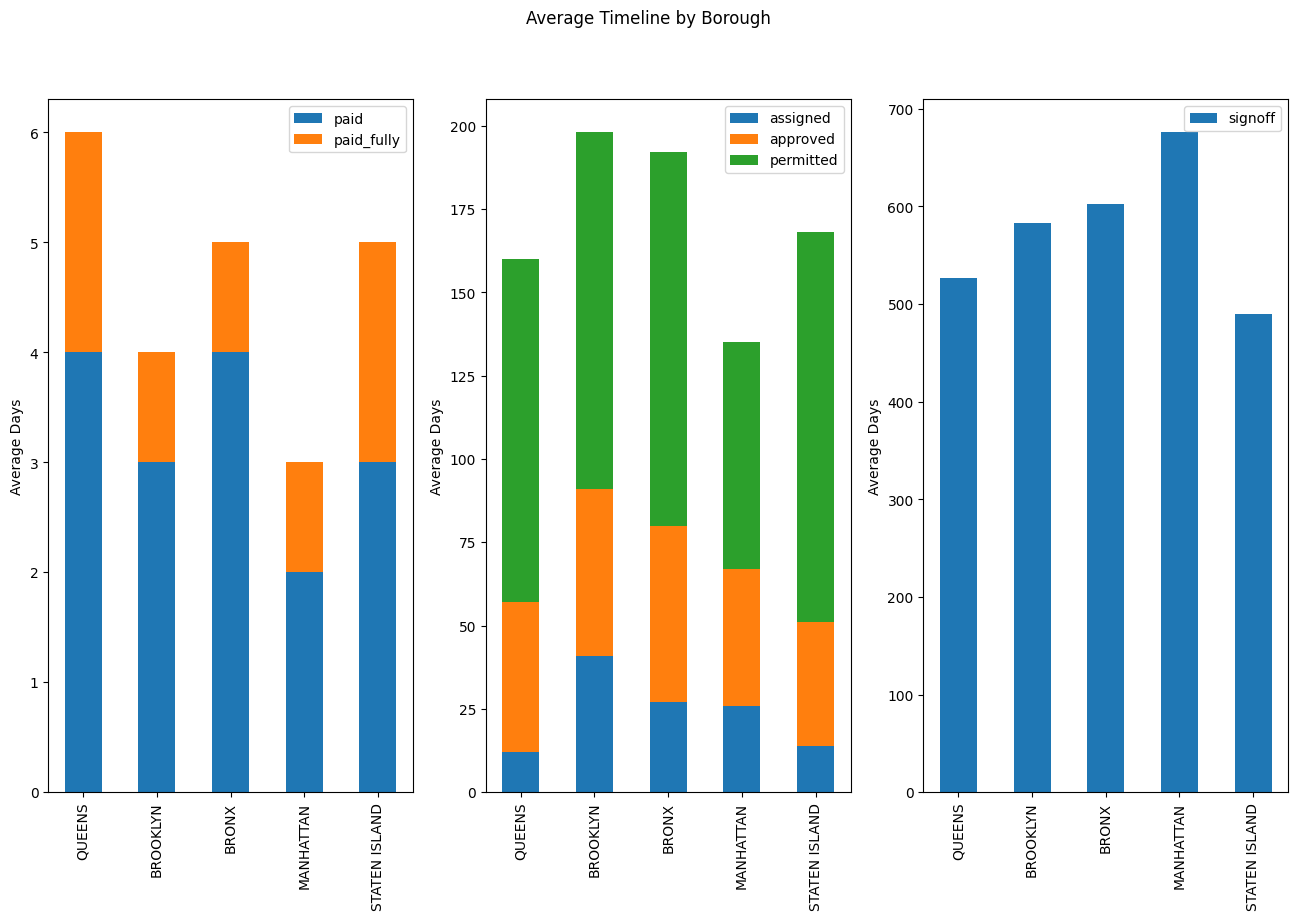

In [16]:
plot_bar(df_timeline_borough, groups, "borough", "Average Timeline by Borough", 0.5)

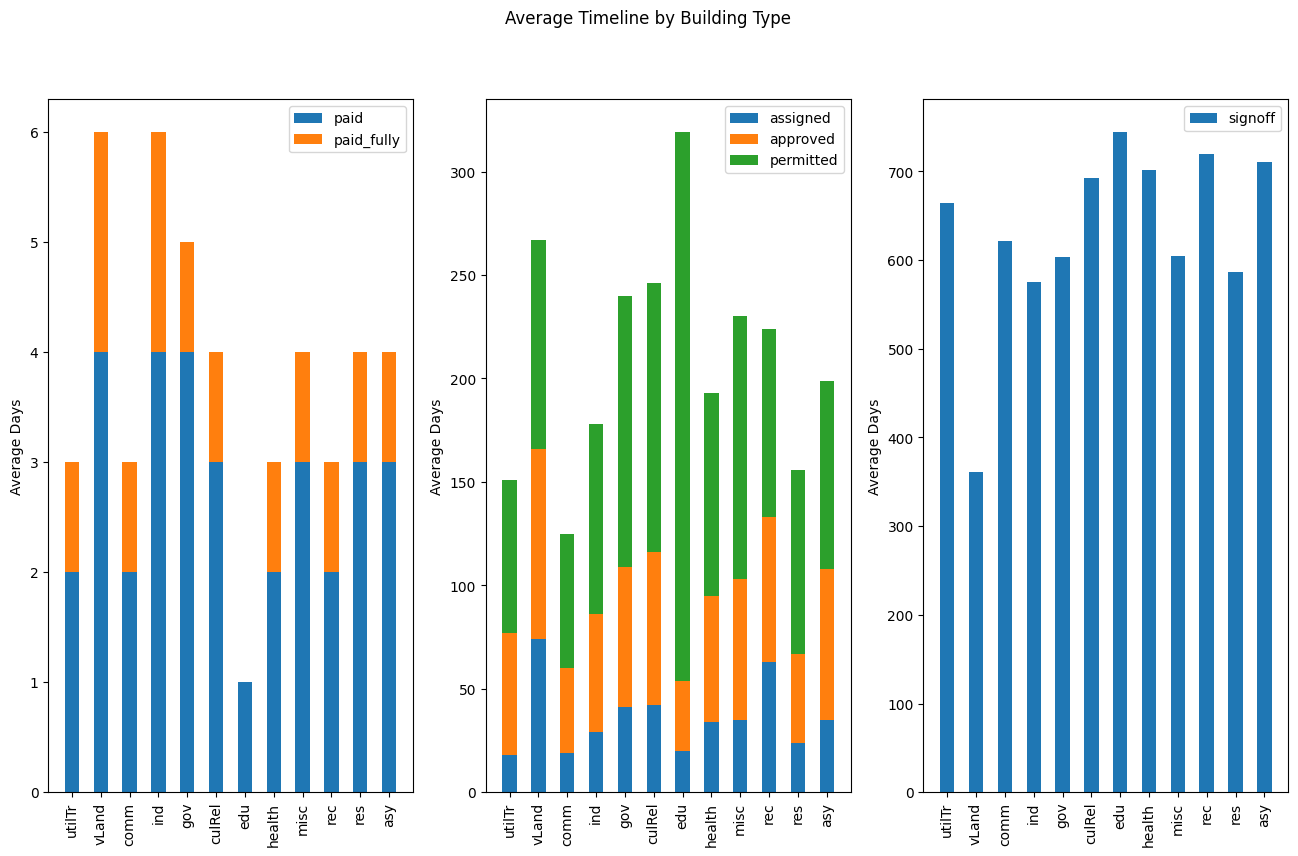

In [17]:
plot_bar(df_timeline_building_type, groups, "building_type", "Average Timeline by Building Type", 0.5)

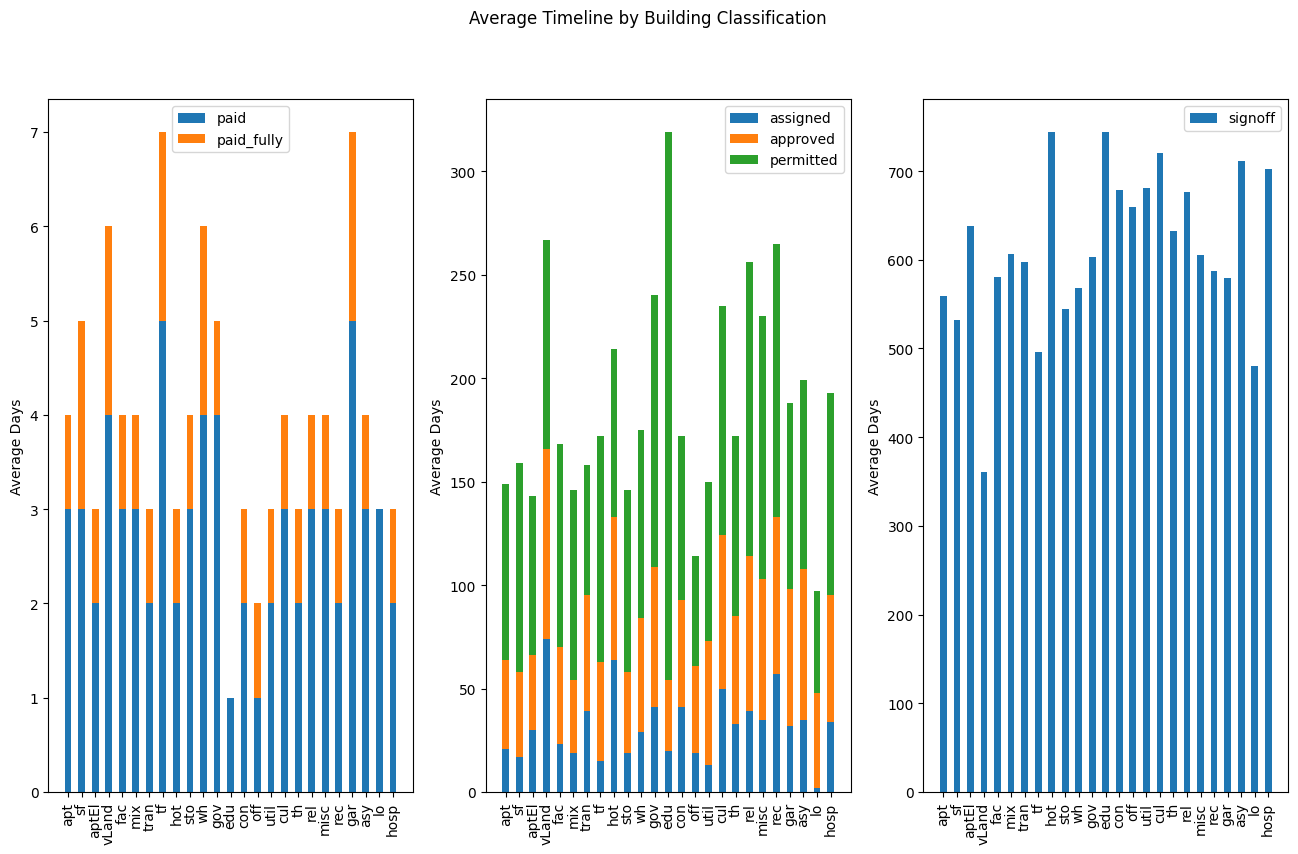

In [18]:
plot_bar(df_timeline_building_class, groups, "building_class", "Average Timeline by Building Classification", 0.5)

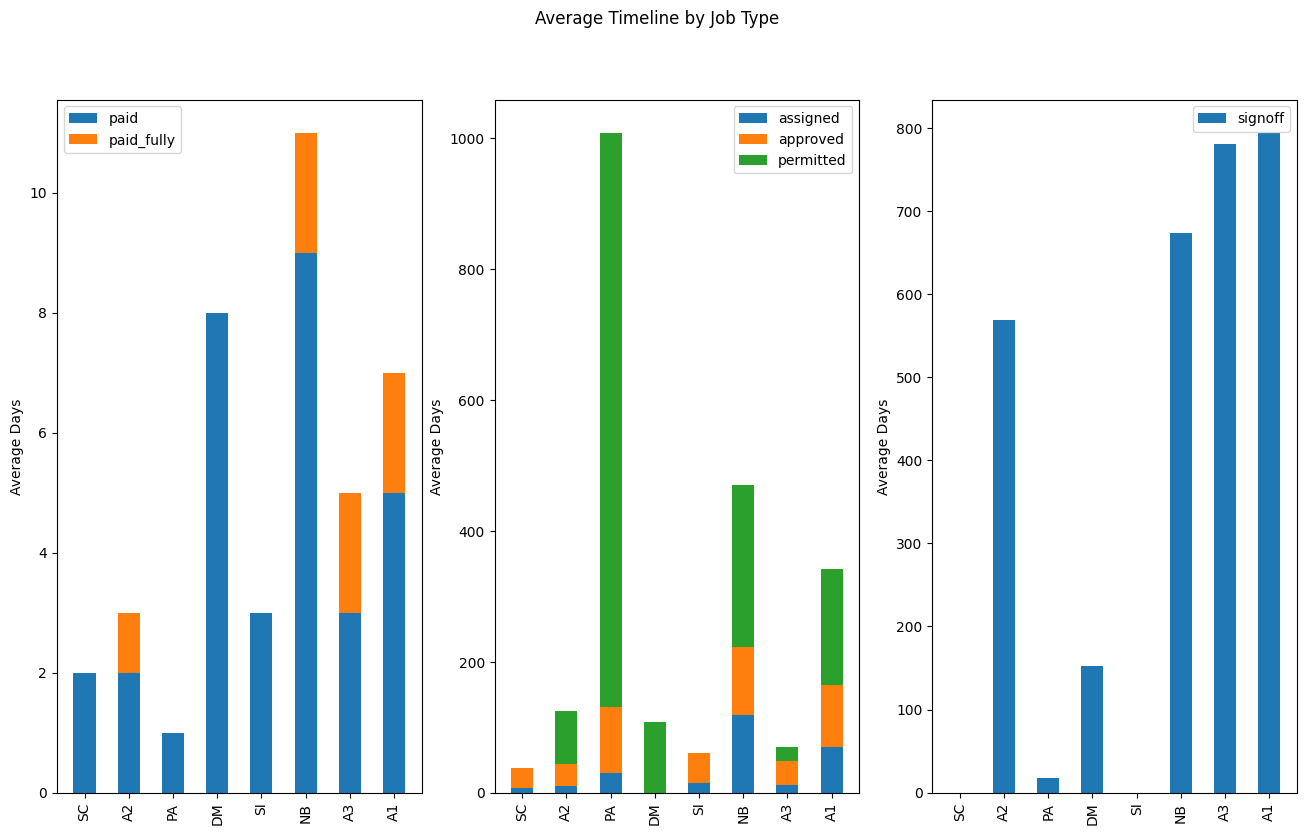

In [19]:
plot_bar(df_timeline_job, groups, "job_type", "Average Timeline by Job Type", 0.5)